# Extract Columns of Interest from TwitterAPI Json result *SIMPLIFIED!*

- Wharton Twitter df has like 60 columns, in this notebook let us focus on like a dozen or so useful columns based on the request for `#epochtimes`

- this is based on timeline of 3,200 tweets returned on 01/25/2021
    - `./data/timeline_epochtimes/raw/epochtimes_2021-01-26.json`

In [1]:
import pandas as pd
import os
from datetime import datetime
import pyarrow

### Twitter API Timeline result ETL
- Looking at Twitter account `epochtimes`

In [2]:
tl_df = pd.read_json('./data/timeline_epochtimes/raw/epochtimes_2021-01-26.json', lines=False)

### Adding the main columns of interest to an `out_df`:

In [3]:
out_df = tl_df[['created_at','id','id_str','retweet_count','favorite_count','favorited']]

### extracting some nested json fields + creating dates

If you want to add additional columns from the raw data json, suggested that you add here


In [4]:
out_df['user_name'] = tl_df.apply(lambda x: x.user['name'], axis=1)
out_df['user_id'] = tl_df.apply(lambda x: x.user['id'], axis=1)
out_df['user_screen_name'] = tl_df.apply(lambda x: x.user['screen_name'], axis=1)

out_df['text'] = tl_df.apply(lambda x: x.full_text, axis=1)

out_df['year'] = pd.DatetimeIndex(tl_df['created_at']).year
out_df['month'] = pd.DatetimeIndex(tl_df['created_at']).month
out_df['day'] = pd.DatetimeIndex(tl_df['created_at']).day
out_df['hour'] = pd.DatetimeIndex(tl_df['created_at']).hour

/Users/etiennejacquot/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/etiennejacquot/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/etiennejacquot/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

## We now have a simplified twitter df!

In [7]:
out_df.head(3)

created_at                   id               id_str  \
0 2021-01-26 03:40:01+00:00  1353910537000000000  1353910536518455296   
1 2021-01-26 03:25:01+00:00  1353906764000000000  1353906764283076608   
2 2021-01-26 03:10:01+00:00  1353902989000000000  1353902988776058880   

   retweet_count  favorite_count  favorited        user_name   user_id  \
0             16              46          0  The Epoch Times  29097819   
1              4              15          0  The Epoch Times  29097819   
2             70             111          0  The Epoch Times  29097819   

  user_screen_name                                               text  year  \
0       EpochTimes  More governors are calling home their #Nationa...  2021   
1       EpochTimes  The US Senate confirmed #JanetYellen as the na...  2021   
2       EpochTimes  Conservative activist #BrandonStraka was arres...  2021   

   month  day  hour  
0      1   26     3  
1      1   26     3  
2      1   26     3

### Export to JSON & Parquet

In [7]:
out_df.to_json('./data/etl/epochtimes_simple_2021-01-26.json')

In [8]:
out_df.to_parquet('./data/etl/epochtimes_simple_2021-01-26.parquet')

________

In [7]:
out_df.dtypes

created_at          datetime64[ns, UTC]
id                                int64
id_str                            int64
retweet_count                     int64
favorite_count                    int64
favorited                         int64
user_name                        object
user_id                           int64
user_screen_name                 object
text                             object
year                              int64
month                             int64
day                               int64
hour                              int64
dtype: object

### *Creating our ASC Twitter API AWS Athena SQL Table*:

- Upload the parquet export to respective S3 bucket, for this example `s3://asctwitterdata/epochtimes_simple/`
    
- Proceed on Athena, make sure to get the correct S3 bucket name & the table dtypes are correct!

    - More info on data types for SERDE parquet table https://docs.aws.amazon.com/athena/latest/ug/data-types.html


### Had to trial and error the dtype in parquet export vs the table creation query dtypes
- Updated with some fields as `string` for Athena table ... againm, this is all in an effort to duplicate the wharton_df columns ... 


To create the `ascdata.parquet_twitter_SIMPLE_epochtimes` table:


You then should be able to query

SAMPLE -- NOT YET TESTED!

___________________


``` sql
CREATE EXTERNAL TABLE IF NOT EXISTS ascdata.parquet_twitter_SIMPLE_epochtimes (
    `created_at` TIMESTAMP,
    `id` int,
    `id_str` string,
    `retweet_count` int,
    `favorite_count` int,
    `favorited` int,
    `user_name` object,
    `user_id` int,
    `user_screen_name` string,
    `text` string,
    `year` int,
    `month` int,
    `day` int,
    `hour` int
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
WITH SERDEPROPERTIES (
  'serialization.format' = '1'
) LOCATION 's3://asctwitterdata/epochtimes_simple/'
TBLPROPERTIES (
  'has_encrypted_data'='false',
  'skip.header.line.count'='1')
```

__________

## Data viz examples on simple timeline twitter df...

In [7]:
out_df.columns

Index(['created_at', 'id', 'id_str', 'retweet_count', 'favorite_count',
       'favorited', 'user_name', 'user_id', 'user_screen_name', 'text', 'year',
       'month', 'day', 'hour'],
      dtype='object')

## Retweet Counts

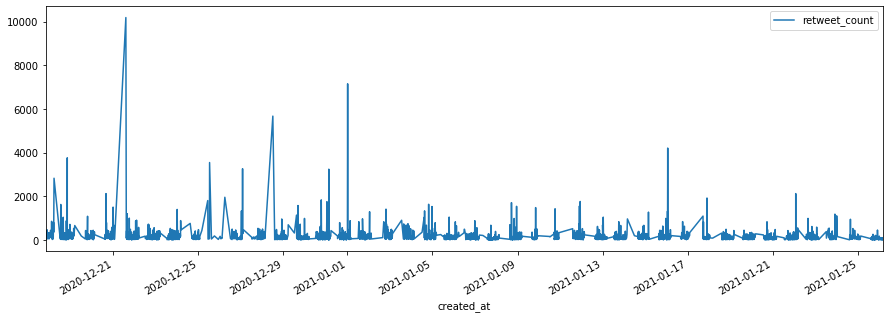

In [10]:
out_df.plot(x='created_at',y='retweet_count',figsize=(15,5))

## Favorite Counts

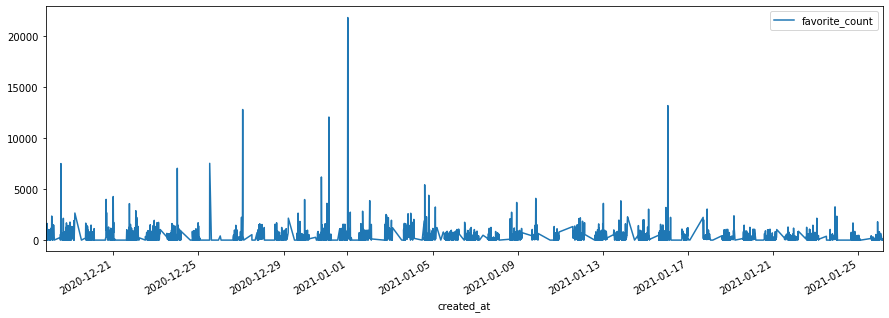

In [9]:
out_df.plot(x='created_at',y='favorite_count',figsize=(15,5))

## NLP for Tweet Text?

In [9]:
tweet_txt = []
for txt in out_df.text.values:
    tweet_txt.append(txt)

### Install dependencies for english nlp

In [10]:
#pip install spacy

In [11]:
#!/Users/etiennejacquot/opt/anaconda3/bin/python3 -m spacy download en_core_web_sm

### These examples are from Mbod's comm313 intro class! 

In [12]:
import spacy
from spacy import displacy

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [13]:
nlp = spacy.load('en_core_web_sm')

In [14]:
epochtimes_tweets = nlp(tweet_txt[12])

for tidx,token in enumerate(epochtimes_tweets[:10]):
    print(tidx,token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
          token.shape_, token.is_alpha, token.is_stop)

0 “ " PUNCT `` punct “ False False
1 With with ADP IN mark Xxxx True True
2 the the DET DT det xxx True True
3 radical radical ADJ JJ nsubj xxxx True False
4 left left NOUN NN advcl xxxx True False
5 now now ADV RB advmod xxx True True
6 in in ADP IN prep xx True True
7 control control NOUN NN pobj xxxx True False
8 of of ADP IN prep xx True True
9 Washington Washington PROPN NNP pobj Xxxxx True False


## Entity & POS

In [15]:
displacy.render(epochtimes_tweets , style='ent', jupyter=True)

In [16]:
displacy.render(epochtimes_tweets, style='dep', jupyter=True)

_________